In [6]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import seaborn as sns

In [61]:
PERFORMANCE_FILE  = "../../results/opt-cnn-performance-metrics-summary-128px.csv"
resolution = PERFORMANCE_FILE.split('-')[-1].split('px')[0]
resolution

'128'

In [62]:
dfm = pd.read_csv(PERFORMANCE_FILE)
num_epochs = dfm.epoch.max()
dfm

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,0.543769,0.726471,0.644109,0.760000,0.658715,0.760000,0.817736,Pr_Im,1
1,1,0.446475,0.790588,0.578282,0.757647,0.653179,0.757647,0.574029,Pr_Im,2
2,2,0.366332,0.842941,0.566988,0.757647,0.653179,0.757647,0.574029,Pr_Im,3
3,3,0.273527,0.900588,0.586245,0.807059,0.792827,0.807059,0.792266,Pr_Im,4
4,4,0.194532,0.937059,0.467972,0.792941,0.730942,0.792941,0.824187,Pr_Im,5
...,...,...,...,...,...,...,...,...,...,...
75,75,0.084835,0.974257,1.388256,0.726733,0.659111,0.726733,0.757758,Pr_Po_Im,16
76,76,0.057625,0.984158,1.552382,0.546535,0.598639,0.546535,0.818447,Pr_Po_Im,17
77,77,0.052520,0.982178,0.843257,0.778218,0.752369,0.778218,0.772664,Pr_Po_Im,18
78,78,0.052531,0.982673,0.734629,0.813861,0.810861,0.813861,0.825554,Pr_Po_Im,19


In [83]:
def plotCNNPerformanceMetrics(resolution):
    performance_file = "../../results/opt-cnn-performance-metrics-summary-" + str(resolution) + "px.csv"
    dfm = pd.read_csv(performance_file)
    num_epochs = dfm.epoch.max()
    melted_df = dfm.melt(id_vars = ["epoch", "Scenario"], value_vars = ["loss", "accuracy", "val_loss", "val_accuracy", "val_f1", "val_precision", "val_recall"], var_name = "metric", value_name = "value")
    melted_df["metric_type"] = None
    melted_df["phase"] = "Validation"
    melted_df.loc[melted_df.metric.isin(["loss", "val_loss"]), "metric_type"] = "Loss"
    melted_df.loc[melted_df.metric.isin(["accuracy", "val_accuracy", "val_f1", "val_precision", "val_recall"]), "metric_type"] = "Performance"
    melted_df.loc[melted_df.metric.isin(["loss", "accuracy"]), "phase"] = "Training"
    #print(melted_df.metric.unique())

    sns.set_style("whitegrid")
    g = sns.FacetGrid(melted_df, col="Scenario", row="metric_type", sharey = False, hue_kws = {"linestyle" : ["-","--"]})
    g.map_dataframe(sns.lineplot, x = "epoch", y = "value", ci=None, hue = "metric", style="phase",  style_order=["Validation", "Training"], alpha=.85,
                    #palette= sns.color_palette("Set2", n_colors=8) 
                   )
    g.set_axis_labels("Epoch", "")
    g.add_legend(bbox_to_anchor=(1.02, .75), loc=2,fontsize=14) 
    ## Customize legend
    g._legend.texts[0].set_text("")
    g._legend.texts[1].set_text("Train. loss") #Data
    g._legend.texts[2].set_text("Val. loss")
    g._legend.texts[3].set_text("")    
    g._legend.texts[4].set_text("")    
    g._legend.texts[5].set_text("")    
    g._legend.texts[6].set_text("Train. accuracy")    
    g._legend.texts[7].set_text("Val. accuracy")    
    g._legend.texts[8].set_text("Avg. F1")    
    g._legend.texts[9].set_text("Avg. Precision")    
    g._legend.texts[10].set_text("Avg. Recall")    
    g._legend.legendHandles[4].set_linewidth(0)
    g._legend.legendHandles[5].set_linewidth(0)    
    g._legend.legendHandles[6].set_linestyle('--')    
    g._legend.legendHandles[1].set_linestyle('--')    

    # g._legend._legend_box.sep = 5
    axes = g.axes
    for row, axlist in enumerate(axes):
        if row==0:
            for col, axis in enumerate(axes[row]):
                axes[row, col].set_ylim(0, dfm.val_loss.max())#.75 
                axes[row, col].set_xlim(1, num_epochs)
                axes[row, col].xaxis.set_major_locator(tkr.AutoLocator())
                axes[row, col].set_title("Scenario: " + str(axes[row, col].title).split("Scenario = ")[1].split(")")[0].split("\'")[0])
                if col != 0:
                    axes[row, col].get_yaxis().set_ticklabels([])
                else:
                    axes[row, col].set_ylabel("Loss", fontsize=14)
        elif row==1:
            for col, axis in enumerate(axes[row]):
                axes[row, col].set_ylim(0.4, 1.05)
                axes[row, col].set_xlim(1, num_epochs)
                axes[row, col].set_title("")
                if col != 0:
                    axes[row, col].get_yaxis().set_ticklabels([])
                else:
                    axes[row, col].set_ylabel("Performance", fontsize=14)
    g.fig.tight_layout()
    g.savefig("../../figures/cnn-performance-metrics-" + str(resolution) + "px-plot.png", dpi=180)
    return

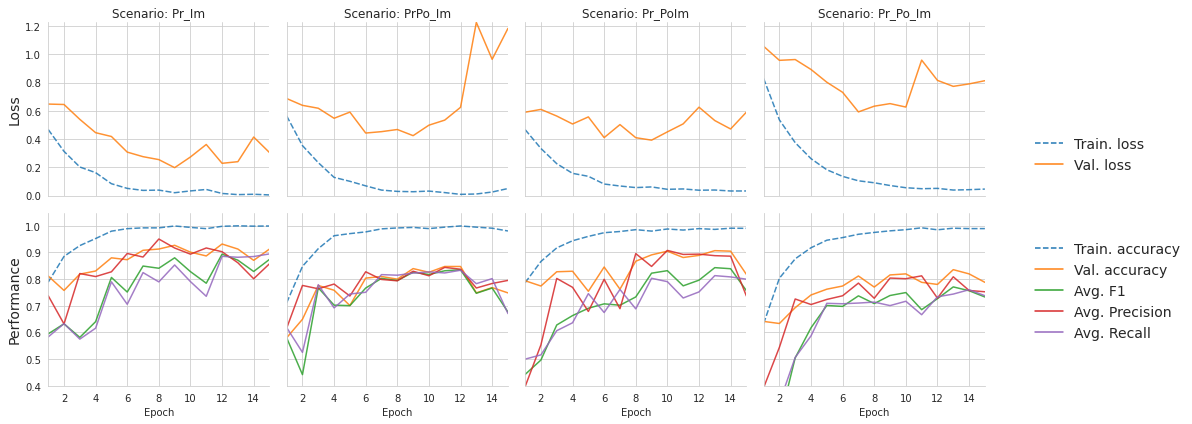

In [84]:
plotCNNPerformanceMetrics(128)